<a href="https://www.kaggle.com/code/ashayjpatel/resnet-chest-xray-pneumonia-detection?scriptVersionId=287845839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
import numpy as np
import os

In [12]:
#Paths
DATASET_DIR = "/kaggle/input/chest-xray-images-guangzhou-women-and-childrens/chest_xray/"
train_dir = os.path.join(DATASET_DIR, "train")
test_dir  = os.path.join(DATASET_DIR, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [14]:
# --- STEP 1: THE GENERATOR (Crucial Change) ---
# REMOVE 'rescale=1./255' and ADD 'preprocessing_function=preprocess_input' (from VGG16)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <--- The ResNet Way
    validation_split=0.2,
    # Add augmentation if you want (rotation, zoom, etc.)
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [15]:
# Load data as usual...
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)



Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [18]:
# --- STEP 2: THE MODEL ---
# Load ResNet50 instead of VGG16
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze it (Same as before)
base_model.trainable = False

# Add the Head (Same as before)
# Note: ResNet often uses GlobalAveragePooling2D instead of Flatten, 
# because the feature maps are deeper (2048 channels!).
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Better than Flatten for ResNet
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # ResNet is powerful, so we prevent overfitting
    layers.Dense(1, activation='sigmoid')
])


In [19]:
# Compile and Train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate weights (or reuse the ones you found earlier)
# Normal (0): ~1.94, Pneumonia (1): ~0.67


# 1. Get all the labels from the generator
# train_generator.classes gives you an array like [0, 0, 1, 1, 1, 0...]
train_labels = train_generator.classes

# 2. Automatically calculate the weights
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# 3. Convert to a dictionary (Keras requires a dictionary {0: weight, 1: weight})
class_weights = dict(enumerate(class_weights_array))

# Print to verify (It should match our manual numbers closely)
print(f"Auto-Calculated Weights: {class_weights}")


Auto-Calculated Weights: {0: np.float64(1.938425925925926), 1: np.float64(0.6738010943031864)}


In [20]:
history = model.fit(
    train_generator,
    epochs=10, # Or whatever you choose
    validation_data=val_generator,
    class_weight=class_weights  
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1766407430.644466     188 service.cc:152] XLA service 0x7cae50013830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766407430.644505     188 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766407430.644510     188 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766407432.546437     188 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/131 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.4766 - loss: 1.4330

I0000 00:00:1766407437.683646     188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 132s 904ms/step - accuracy: 0.8066 - loss: 0.5549 - val_accuracy: 0.9187 - val_loss: 0.2041
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 701ms/step - accuracy: 0.9297 - loss: 0.1925 - val_accuracy: 0.9311 - val_loss: 0.1602
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 697ms/step - accuracy: 0.9380 - loss: 0.1551 - val_accuracy: 0.9282 - val_loss: 0.1741
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 694ms/step - accuracy: 0.9475 - loss: 0.1376 - val_accuracy: 0.9139 - val_loss: 0.2257
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 695ms/step - accuracy: 0.9504 - loss: 0.1302 - val_accuracy: 0.9541 - val_loss: 0.1128
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 699ms/step - accuracy: 0.9592 - loss: 0.1115 - val_accuracy: 0.9694 - val_loss: 0.0914
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 707ms/step - accuracy: 0.9555 - loss: 0.1140 - val_accuracy: 0.9397 - val_loss: 0.1358
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 695ms/step - accuracy: 0.9624 - loss: 0.1043 - va

In [23]:
model.save("ResNet_pneumonia_cnn.keras")

In [30]:
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [39]:
#Final evaluation (true test set)
test_gen.reset()
pred_probs = model.predict(test_gen)
pred_labels = (pred_probs > 0.1).astype(int).ravel()
true_labels = test_gen.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step


In [40]:
from sklearn.metrics import classification_report

print(
    classification_report(
        true_labels,
        pred_labels,
        target_names=["Normal", "Pneumonia"]
    )
)


              precision    recall  f1-score   support

      Normal       0.90      0.85      0.88       234
   Pneumonia       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



Generating Heatmap...


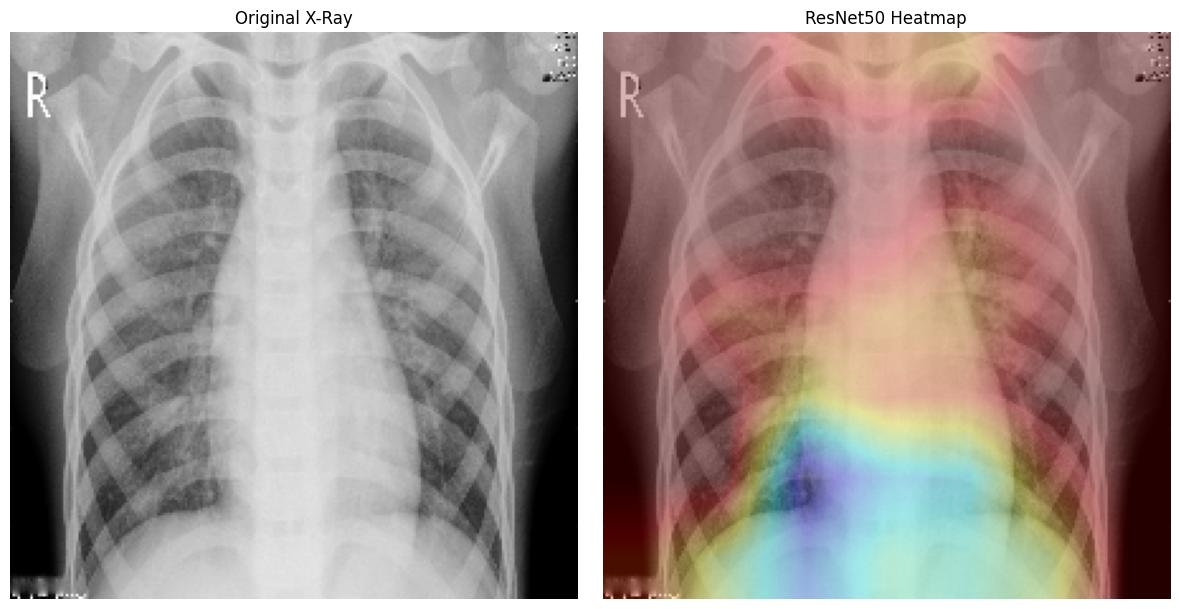

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- 1. THE ROBUST GRAD-CAM FUNCTION ---
def make_gradcam_heatmap_manual(img_array, model, pred_index=None):
    # We assume model.layers[0] is the ResNet50 Base
    # We assume model.layers[1:] are the Head (Pooling, Dense, Dropout, Dense)
    
    # Isolate the parts
    base_model = model.layers[0]
    classifier_layers = model.layers[1:]
    
    with tf.GradientTape() as tape:
        # STEP 1: Run image through the Base (ResNet)
        # We watch this output because we need its gradient
        conv_outputs = base_model(img_array)
        tape.watch(conv_outputs)
        
        # STEP 2: Run that output through the rest of the layers manually
        preds = conv_outputs
        for layer in classifier_layers:
            preds = layer(preds)
            
        # Get the top predicted class
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # STEP 3: Gradient Calculation
    # We want the gradient of the "Prediction" with respect to the "ResNet Output"
    grads = tape.gradient(class_channel, conv_outputs)

    # STEP 4: Global Average Pooling of Gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # STEP 5: Weighting the Feature Map
    # Multiply the feature map (conv_outputs) by the "importance" (pooled_grads)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- 2. RUN IT ---
# Pick a test image (Pneumonia)
img_dir = '/kaggle/input/chest-xray-images-guangzhou-women-and-childrens/chest_xray/test/PNEUMONIA'
img_name = os.listdir(img_dir)[0]
img_path = os.path.join(img_dir, img_name)

# Preprocess (ResNet Style)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

# Generate
print("Generating Heatmap...")
heatmap = make_gradcam_heatmap_manual(img_array, model)

# --- 3. VISUALIZE ---
img_original = cv2.imread(img_path)
img_original = cv2.resize(img_original, (224, 224))

# Colorize
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_resized = np.uint8(255 * heatmap_resized)
jet_heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose
superimposed_img = jet_heatmap * 0.4 + img_original
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title("Original X-Ray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("ResNet50 Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()